In [1]:
# SARIMAX TUTORIAL
# Kaggle: https://www.kaggle.com/code/vipin20/arima-sarimax-exponential-smoothing-using-optuna

In [2]:
import datetime
import itertools
import os
import warnings
from datetime import datetime

import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import statsmodels.api as sm
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def parser(s):
    return datetime.strptime(s, "%Y-%m-%d")

In [4]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/selva86/datasets/master/a10.csv",
    index_col=0,
    parse_dates=[0],
    date_parser=parser,
)

Total no of records :  204


<Axes: xlabel='date'>

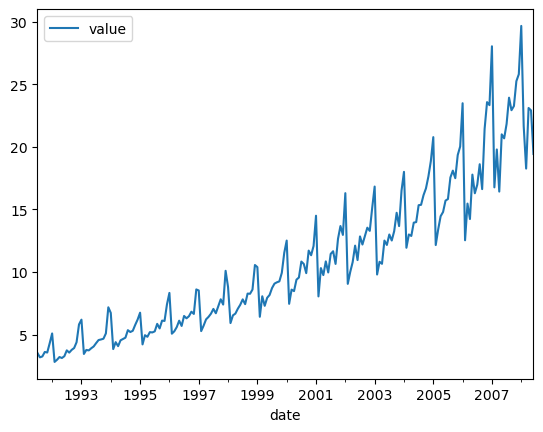

In [5]:
print("Total no of records : ", df.shape[0])
df.plot()

In [6]:
train_data = df[0:184]
print("Total no of training samples :", train_data.shape[0])

test_data = df[184:]
print("Total no of testing samples :", test_data.shape[0])

Total no of training samples : 184
Total no of testing samples : 20


In [7]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


def objective_sarima(trial):
    train_data_obj = train_data[:-20]
    valid_data_obj = train_data[-20:]

    order = trial.suggest_categorical("order", pdq)
    seasonal_order = trial.suggest_categorical("seasonal_order", pdqs)
    trend = trial.suggest_categorical("trend", ["n", "c", "t", "ct", None])
    model = SARIMAX(
        train_data_obj,
        order=order,
        seasonal_order=seasonal_order,
        trend=trend,
        initialization="approximate_diffuse",
    )
    model = model.fit(disp=0)
    predictions = model.forecast(len(valid_data_obj))
    predictions = pd.Series(predictions, index=valid_data_obj.index)
    residuals = valid_data_obj.values - predictions.values
    rmse = np.sqrt(np.mean(residuals**2))
    accuracy = rmse
    return accuracy


if os.path.isfile("sarima_study.pkl"):
    study = joblib.load("sarima_study.pkl")
else:
    study = optuna.create_study()
    study.optimize(objective_sarima, n_trials=20, timeout=3600)
    joblib.dump(study, "sarima_study.pkl")

In [8]:
trial = study.best_trial
print("Accuracy: {}".format(trial.value))
print("Best params for SARIMAX: {}".format(trial.params))

Accuracy: 2.9819518074710225
Best params for SARIMAX: {'order': (2, 0, 0), 'seasonal_order': (2, 0, 2, 12), 'trend': 'ct'}


In [9]:
model = SARIMAX(
    train_data, initialization="approximate_diffuse", **trial.params
)

model = model.fit(disp=0)

In [10]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   value   No. Observations:                  184
Model:             SARIMAX(2, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood                -422.311
Date:                                 Fri, 10 Nov 2023   AIC                            862.621
Time:                                         16:42:11   BIC                            891.556
Sample:                                     07-01-1991   HQIC                           874.349
                                          - 10-01-2006                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5615      0.182      3.080      0.002       0.204       0

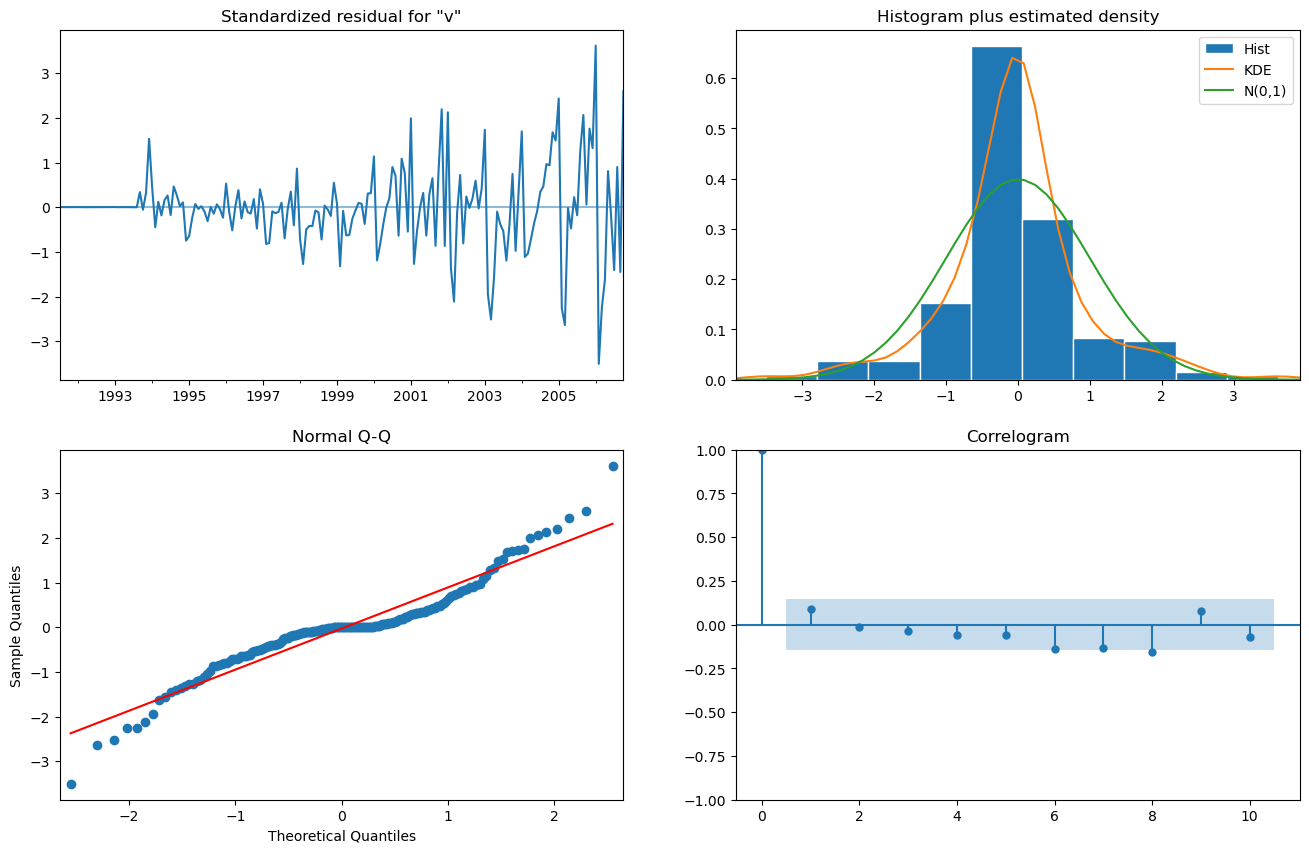

In [11]:
model.plot_diagnostics(figsize=(16, 10));

In [12]:
predictions = model.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data.values - predictions.values

In [13]:
print(
    "Mean absolute error :- ",
    round(mean_absolute_error(test_data, predictions), 5),
)
print(
    "Mean squared error :- ",
    round(mean_squared_error(test_data, predictions), 5),
)
print(
    "Root mean squared error :- ",
    round(mean_squared_error(test_data, predictions, squared=False), 5),
)

Mean absolute error :-  3.07186
Mean squared error :-  12.32175
Root mean squared error :-  3.51024


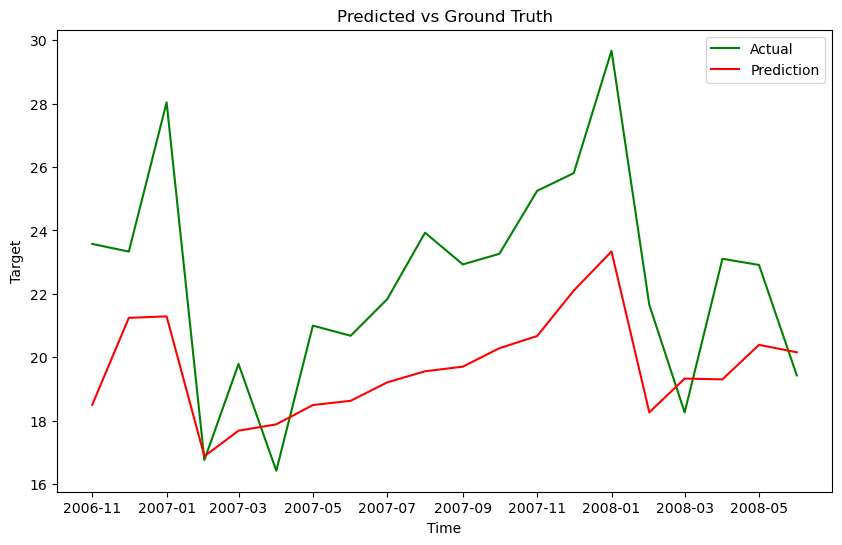

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(test_data, color="green")
plt.plot(predictions, color="red")
plt.legend(["Actual", "Prediction"])
plt.title("Predicted vs Ground Truth")
plt.xlabel("Time")
plt.ylabel("Target")
plt.show()